# Using the Sobel angle similarity model with various descriptors to fit the data in Bushdid et al.

In [24]:
%matplotlib inline

# Basic python libraries.  
import sys,csv,urllib,json
from collections import OrderedDict as odict
from pprint import pprint

# Numerical and graphing libraries I used.  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import linregress,norm,binom
from scipy.optimize import fmin,fmin_tnc,fmin_l_bfgs_b
from sklearn.preprocessing import scale
from sklearn.decomposition import NMF,PCA

# Path to my code related to Bushdid et al. 
sys.path.append('/Users/rgerkin/Dropbox/science/trillion')  
import trillion

#### Load and format the Snitz et al. data

In [3]:
CIDs_snitz = {} # To store Snitz et al. descriptors.  
CIDs_all = {} # To store all descriptors.  

# The 21 molecular descriptors "discovered" in Snitz et al.  
snitz_descriptors = ['nCIR','ZM1','GNar','S1K','piPC08','MATS1v','MATS7v',]
snitz_descriptors += ['GATS1v','EEig05x','ESpm02x','ESpm03d','ESpm10d','ESpm13d','BELv3']
snitz_descriptors += ['RDF035v','G1m','G1v','G1e','G3s','R8u+','nRCOSR']

# Create dictionaries of descriptor values for molecules in Snitz using their supplemental table.  
# Their supplemental table has >1000 descriptors for each molecule, which is a good fraction of what is in Dragon.  
with open('data/snitz_tableS1.csv') as f:
    reader = csv.reader(f)
    descriptors = reader.__next__()[1:]
    for line in reader:
        CID = int(float(line[0]))
        values = [float(_) for i,_ in enumerate(line[1:]) if descriptors[i] in snitz_descriptors]
        CIDs_snitz[CID] = odict(zip(snitz_descriptors,values))
        values_all = [float(_) for i,_ in enumerate(line[1:])]
        CIDs_all[CID] = odict(zip(descriptors,values_all))
        
# The descriptors in the Snitz supplemental table are already normalized to 0.0 (min value across molecules) to 1.0 (max).  
# Make a matrix of CIDs by descriptor values.  
x = np.array([[CIDs_all[CID][descriptor] for descriptor in descriptors] for CID in CIDs_all.keys()])
#x = scale(x) # Scale to mean=0, variance=1.  
CIDs_all_normed,CIDs_normed = {},{}
for i,CID in enumerate(CIDs_all):
    CIDs_all_normed[CID] = {}
    CIDs_normed[CID] = {}
    for j,descriptor in enumerate(descriptors):
        CIDs_all_normed[CID][descriptor] = x[i,j]
        if descriptor in snitz_descriptors:
            CIDs_normed[CID][descriptor] = x[i,j]

In [4]:
print("There are %d CIDs and %d molecular descriptors" % (x.shape[0],x.shape[1]))

There are 1318 CIDs and 1433 molecular descriptors


In [5]:
# Verify that x matrix and dictionary are in register, as intended by use of OrderedDict.  
print(list(list(CIDs_all.values())[0].values())[:10]) # First 10 molecular descriptors for first molecule.  
print(x[0,:10]) # First 10 molecular descriptors for first molecule.  

[0.25, 0.0, 0.4, 0.43, 0.43, 0.16, 0.04, 0.07, 0.03, 0.12]
[ 0.25  0.    0.4   0.43  0.43  0.16  0.04  0.07  0.03  0.12]


In [6]:
CIDs_snitz[8193] # Ordered list of Snitz descriptors and corresponding values for the molecule with (for example) CID 8193.  

OrderedDict([('nCIR', 0.0), ('ZM1', 0.18), ('GNar', 0.58), ('S1K', 0.33), ('piPC08', 0.24), ('MATS1v', 0.5), ('MATS7v', 0.26), ('GATS1v', 0.27), ('EEig05x', 0.55), ('ESpm02x', 0.53), ('ESpm03d', 0.24), ('ESpm10d', 0.19), ('ESpm13d', 0.34), ('BELv3', 0.85), ('RDF035v', 0.03), ('G1m', 0.03), ('G1v', 0.02), ('G1e', 0.02), ('G3s', 0.17), ('R8u+', 0.23), ('nRCOSR', 0.0)])

#### Load and format the Bushdid et al. data

In [7]:
# Load the mixture components from Bushdid et al. using their supplemental information (Bushdid-tableS1.csv).  
components = trillion.load_components()
# Load the Bushdid et al. odorants, tests, and test results using their supplemental information (Bushdid-tableS2.csv).
odorants,tests,results = trillion.load_odorants_tests_results(components)

#### Quick check with PCA

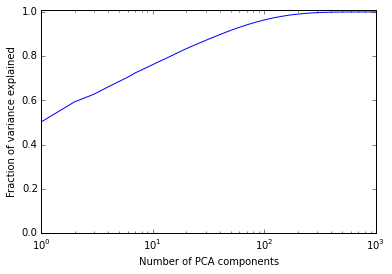

In [7]:
# Get an idea for the largest number of dimensions in the molecular descriptor data set.  
pca = PCA()
pca.fit(x)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xscale('log')
plt.xlim(0,1000)
plt.ylim(0,1.01)
plt.xlabel('Number of PCA components')
plt.ylabel('Fraction of variance explained')

#### Non-negative matrix factorization (NMF) of the molecular descriptor matrix

In [8]:
# Non-negative matrix factorization of the x matrix.  
nmf_200 = NMF(n_components=200, nls_max_iter=500) # 200 determined to be reasonable in a separate analysis.  
nmf_200.fit(x) # Fit the x matrix to this NMF basis.  

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/decomposition/nmf.py:252: UserWarning: Iteration limit reached in nls subproblem.
  warnings.warn("Iteration limit reached in nls subproblem.")
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/decomposition/nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


NMF(beta=1, eta=0.1, init=None, max_iter=200, n_components=200,
  nls_max_iter=500, random_state=None, sparseness=None, tol=0.0001)

In [9]:
print("Total reconstruction error using %d components is %.2f" % (nmf_200.components_.shape[1],nmf_200.reconstruction_err_))
x_nmf_200 = nmf_200.transform(x) # Transformation of x using this NMF basis.  
print("Transformed matrix has %d molecules and %d descriptor dimensions" % (x_nmf_200.shape[0],x_nmf_200.shape[1]))

Total reconstruction error using 1433 components is 28.60
Transformed matrix has 1318 molecules and 200 descriptor dimensions


In [10]:
# Create a new ordered dictionary from the NMF transformation.  
CIDs_nmf_200 = {}
for i,CID in enumerate(CIDs_all):
    CIDs_nmf_200[CID] = odict()
    for j in range(x_nmf_200.shape[1]):
        CIDs_nmf_200[CID][j] = x_nmf_200[i,j]

N	r	Var exp\Var obs	f_correct
10	10	0.271		0.652
10	7	0.300		0.638
30	10	0.356		0.529
30	20	0.375		0.602
10	1	0.405		0.452
20	1	0.493		0.358
20	20	0.513		0.673
20	15	0.547		0.633
20	10	0.589		0.527
20	5	0.643		0.456
10	4	0.679		0.548
30	1	0.920		0.365
30	30	1.361		0.698


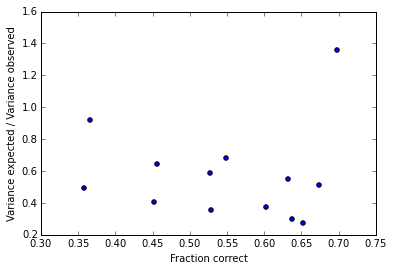

In [61]:
fraction_correct = {}
for test in tests.values():
    if test.N > 1 and test.r != 8:
        key = '%d_%d' % (test.N,test.r)
        if key not in fraction_correct:
            fraction_correct[key] = []
        fraction_correct[key].append(test.fraction_correct(results))
        
variances = []
for key,values in fraction_correct.items():
    values = np.array(values)
    expected = 26*values.mean()*(1-values.mean())
    observed = (values*26).var()
    variances.append((key,expected/observed,values.mean()))
variances = sorted(variances,key=lambda x:x[1])
print('N\tr\tVar exp\Var obs\tf_correct')
for variance in variances:
    N,r = variance[0].split('_')
    print("%d\t%d\t%.3f\t\t%.3f" % (int(N),int(r),variance[1],variance[2]))
plt.scatter(list(zip(*variances))[2],list(zip(*variances))[1])
plt.xlabel('Fraction correct')
_ = plt.ylabel('Variance expected / Variance observed')

In [49]:
list(zip(*variances))[0]

('10_10',
 '10_7',
 '30_10',
 '30_20',
 '10_1',
 '20_1',
 '20_20',
 '20_15',
 '20_10',
 '20_5',
 '10_4',
 '30_1',
 '30_30')

#### Functions to compute angle distance between mixtures, make plots and fits, and compute variance explained

In [22]:
def compute_angles(tests,results,descriptors,weights=None,method='sum',method_param=1.0):
    """Computes angles between mixtures given descriptors to use and optional weights for each descriptor."""
    angles = {10:[],20:[],30:[]}
    fraction_correct = {10:[],20:[],30:[]}
    for test in tests.values():
        if test.N > 1:
            angles[test.N].append(test.angle(descriptors,weights=weights,method=method,method_param=method_param))
            fraction_correct[test.N].append((test.fraction_correct(results),test.r))
    for N in 10,20,30:
        angles[N] = np.array(angles[N])
        fraction_correct[N] = np.array(fraction_correct[N])
    return angles, fraction_correct

def compute_norms(tests,results,descriptors,weights=None,order=2,method='sum'):
    """Computes angles between mixtures given descriptors to use and optional weights for each descriptor."""
    norms = {10:[],20:[],30:[]}
    fraction_correct = {10:[],20:[],30:[]}
    for test in tests.values():
        if test.N > 1:
            norms[test.N].append(test.norm(descriptors,weights=weights,order=order,method=method)/test.N)
            fraction_correct[test.N].append((test.fraction_correct(results),test.r))
    for N in 10,20,30:
        norms[N] = np.array(norms[N])
        fraction_correct[N] = np.array(fraction_correct[N])
    return norms, fraction_correct

In [9]:
def get_r2(prediction,observed):
    """Compute the coefficient of determination R^2 from the data"""
    ss_error = np.sum((observed-prediction)**2)
    ss_total = np.sum((observed-observed.mean())**2)
    return 1 - ss_error/ss_total

def f_hill(params,x,y):
    a,n = params
    p_d = 1.0 / (1.0 + (x/a)**(-n))
    p_c = 1.0/3 + p_d*(2.0/3)
    ll = binom.logpmf((y*26).astype(int),26,p_c).sum() # 26 subjects.  
    return -ll
    
def plot_correct_vs_angles(angles, fraction_correct, color_d=False):
    """Plot angles from Snitz-like (angle-based) calculations, as well as the fraction correct for the same mixtures."""
    fig,ax = plt.subplots(3,2,figsize=(12,12))
    N_colors = {10:'r',20:'g',30:'b'}
    
    for i,N in enumerate([10,20,30]):
        d_colors = [cm.get_cmap('rainbow',N)(int(r-1)) for r in fraction_correct[N][:,1]]
        ax[i,0].scatter(angles[N],fraction_correct[N][:,0],color=d_colors if color_d else N_colors[N],label='N=%d' % N)
        ax[i,0].set_xlabel('Angle distance between mixtures')
        ax[i,0].set_ylabel('Fraction correctly discriminated')
        min_angle = np.min(np.concatenate((angles[10],angles[20],angles[30])))
        max_angle = np.max(np.concatenate((angles[10],angles[20],angles[30])))
        ax[i,0].set_xlim(min_angle/1.1,max_angle*1.1)
        ax[i,0].set_ylim(-0.1,1)
        x = angles[N]
        y = fraction_correct[N][:,0]
        x = np.concatenate((x,x.min()*np.ones(100)))
        y = np.concatenate((y,0.33333*np.ones(100)))
        slope, intercept, _ , _, _ = linregress(x,y)
        prediction = np.array([intercept + slope*angle for angle in angles[N]])
        prediction[np.where(prediction>1.0)] = 1.0
        #a,n = fmin_tnc(f_hill,[0.1,2],approx_grad=True,args=(x,y),bounds=((0,99),(-99,99)))[0]
        #p_d = 1.0 / (1.0 + (x/a)**(-n))
        #prediction = 1.0/3 + p_d*(2.0/3)
        r2 = get_r2(prediction,fraction_correct[N][:,0])
        r2_random = []
        for _ in range(100):
            random = np.random.binomial(26,prediction)/26
            r2_random.append(get_r2(prediction,random))
        r2_random = np.mean(r2_random)
        x = np.linspace(x.min(),x.max(),100)
        y = intercept + slope*x
        #p_d = 1.0 / (1.0 + (x/a)**(-n))
        #y = 1.0/3 + p_d*(2.0/3)
        d_colors = cm.get_cmap('rainbow',N)
        ax[i,0].plot(x,y,color='k' if color_d else N_colors[N],
                     label='slope=%.2f, r=%.2f, R^2=%.2f' % (slope,np.sqrt(r2),r2/r2_random))
        #ax[i,0].set_xscale('log')
        ax[i,0].legend(loc=4)

        z = abs(fraction_correct[N][:,0]-prediction) / (np.sqrt(prediction*(1-prediction))/np.sqrt(26))
        ax[i,1].plot(sorted(z),np.linspace(0,1,len(z)),color=N_colors[N],label='data')
        ax[i,1].plot(sorted(z),1-2*(1-norm.cdf(sorted(z))),color='k',label='Null hypothesis')
        ax[i,1].set_xlim(0,5)
        ax[i,1].set_xlabel('Squared normalized deviation')
        ax[i,1].set_ylabel('Cumulative fraction')
        ax[i,1].legend()

#### Check the raw Snitz model (21 descriptors, equal weight) against the Bushdid et al. data<br> Left panels: x-axis is Snitz angles; y-axis is Bushdid data.<br> Right panels: A measure of how close the fit is to perfection (i.e. chi-squared distributed squared errors)<br> N=10,20,30 is number of components in a mixture.<br>   See distinction between r and R^2 below.  

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:54: RuntimeWarning: divide by zero encountered in true_divide


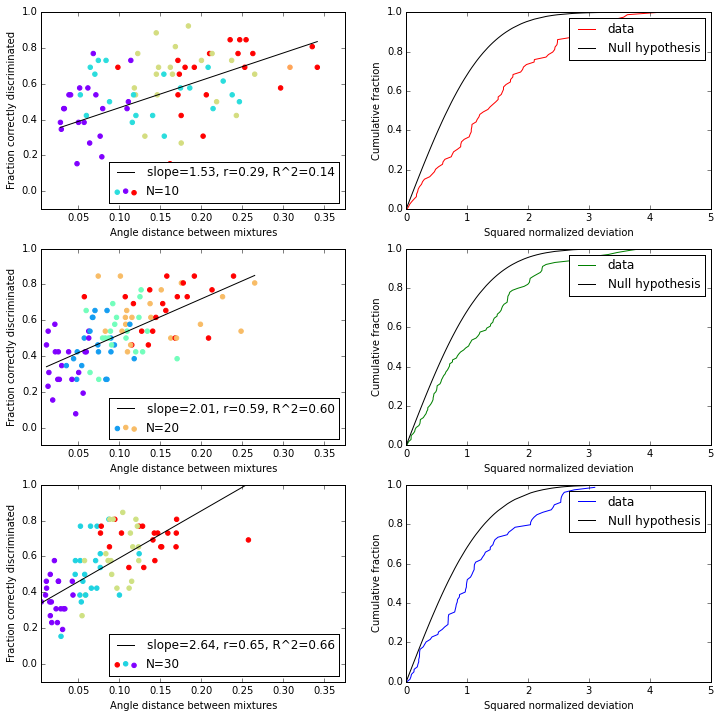

In [20]:
# Compute inter-mixture angles (Snitz style, using the 21 Snitz descriptors) and fraction correct for the data in Bushdid et al. 
angles, fraction_correct = compute_angles(tests,results,CIDs_snitz)

# Plot the results.  
# r = correlation coefficient.  R^2 = coefficient of determination normalized to best possible given finite data.  
plot_correct_vs_angles(angles, fraction_correct, color_d=True)

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:50: RuntimeWarning: invalid value encountered in sqrt
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:54: RuntimeWarning: divide by zero encountered in true_divide


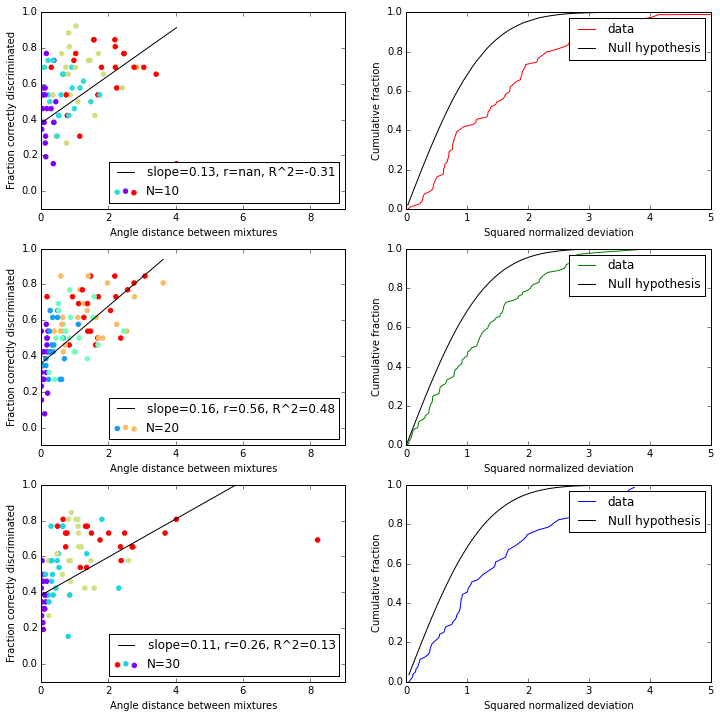

In [23]:
# Compute inter-mixture angles (Snitz style, using the 21 Snitz descriptors) and fraction correct for the data in Bushdid et al. 
norms, fraction_correct = compute_norms(tests,results,CIDs_snitz)

# Plot the results.  
# r = correlation coefficient.  R^2 = coefficient of determination normalized to best possible given finite data.  
plot_correct_vs_angles(norms, fraction_correct, color_d=True)

#### Same thing but for the descriptors extracted through NMF

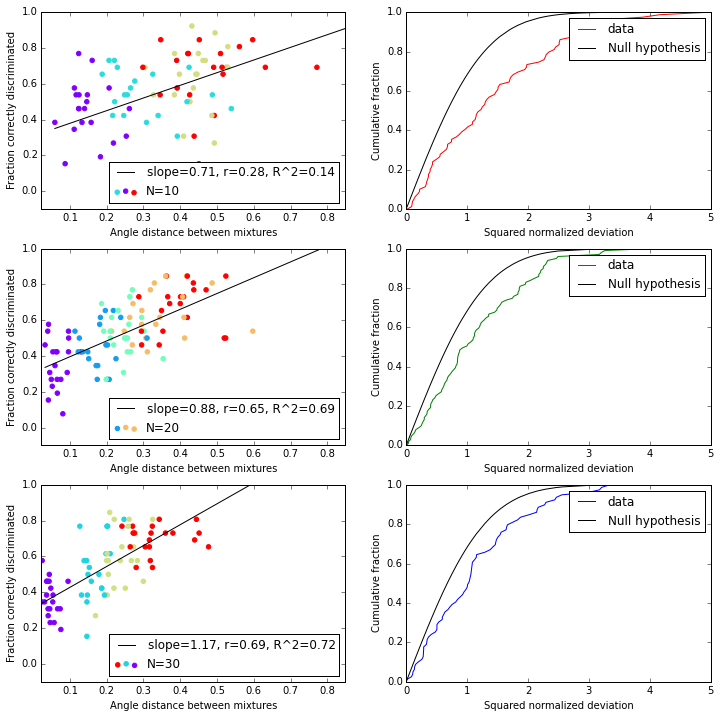

In [171]:
angles_nmf_200, fraction_correct = compute_angles(tests,results,CIDs_nmf_200)
plot_correct_vs_angles(angles_nmf_200, fraction_correct, color_d=True)

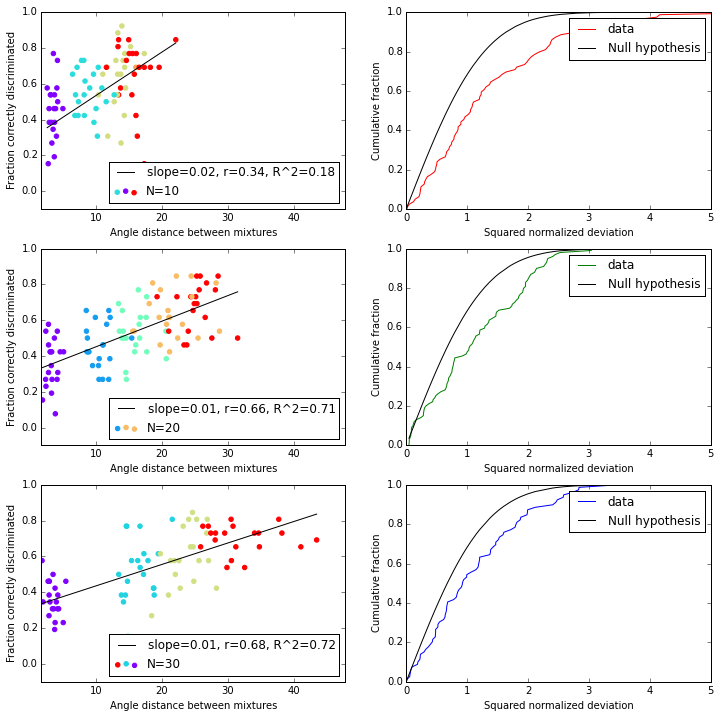

In [186]:
norms_nmf_200, fraction_correct = compute_norms(tests,results,CIDs_nmf_200,order=1)
plot_correct_vs_angles(norms_nmf_200, fraction_correct, color_d=True)

#### An optimization function that uses L1 penalized regression (i.e. Lasso) to get the best fit for the N=10 and N=30 cases, and then tests out of sample on the N=20 cases

In [188]:
def f(weights,descriptors,alpha,tests,results):
    angles = {10:[],20:[],30:[]}
    fraction_correct = {10:[],20:[],30:[]}
    for test in tests.values():
        if test.N > 1:
            angles[test.N].append(test.angle(descriptors,weights=weights,method='sum'))
            fraction_correct[test.N].append(test.fraction_correct(results))
    r2s = []
    sses = []
    for N in 10,30:
        angles[N] = np.array(angles[N])
        fraction_correct[N] = np.array(fraction_correct[N])
        x = angles[N]
        y = fraction_correct[N]
        x = np.concatenate((x,np.zeros(100)))
        y = np.concatenate((y,0.33333*np.ones(100)))
        slope, intercept, _, _, _ = linregress(x,y)
        prediction = np.array([intercept + slope*angle for angle in angles[N]])
        #a,n = fmin_tnc(f_hill,[0.1,2],approx_grad=True,args=(x,y),bounds=((0,99),(-99,99)))[0]
        #print(N,a,n,weights)
        #p_d = 1.0 / (1.0 + (x/a)**(-n))
        #prediction = 1.0/3 + p_d*(2.0/3)
        r2 = get_r2(prediction,fraction_correct[N])
        sse = np.mean((prediction-fraction_correct[N])**2)
        r2s.append(r2)
        sses.append(sse)
    obj = np.mean(sses) + alpha*np.abs(weights).sum()
    if np.random.randint(25) == 0:
        print('%.3g' % obj)#,len(np.where(np.abs(weights)>0.1)[0]),r2s)
    return obj

#### Fit and plot the weighted Snitz descriptors (weighted according to regression above)

In [152]:
fitted_weights = np.ones(len(snitz_descriptors))
fitted_weights = fmin_l_bfgs_b(f,fitted_weights,fprime=None,args=(CIDs_snitz,1e-4,tests,results),approx_grad=True,maxiter=1e6)[0]

0.025
0.024
0.023
0.023
0.023
0.023
0.022
0.022
0.022
0.022
0.022
0.022
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.023
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.021
0.02

In [189]:
def f_norm(weights,descriptors,alpha,tests,results):
    angles = {10:[],20:[],30:[]}
    fraction_correct = {10:[],20:[],30:[]}
    for test in tests.values():
        if test.N > 1:
            angles[test.N].append(test.norm(descriptors,order=1,weights=weights,method='sum'))
            fraction_correct[test.N].append(test.fraction_correct(results))
    r2s = []
    sses = []
    for N in 10,30:
        angles[N] = np.array(angles[N])
        fraction_correct[N] = np.array(fraction_correct[N])
        x = angles[N]
        y = fraction_correct[N]
        x = np.concatenate((x,np.zeros(100)))
        y = np.concatenate((y,0.33333*np.ones(100)))
        slope, intercept, _, _, _ = linregress(x,y)
        prediction = np.array([intercept + slope*angle for angle in angles[N]])
        #a,n = fmin_tnc(f_hill,[0.1,2],approx_grad=True,args=(x,y),bounds=((0,99),(-99,99)))[0]
        #print(N,a,n,weights)
        #p_d = 1.0 / (1.0 + (x/a)**(-n))
        #prediction = 1.0/3 + p_d*(2.0/3)
        r2 = get_r2(prediction,fraction_correct[N])
        sse = np.mean((prediction-fraction_correct[N])**2)
        r2s.append(r2)
        sses.append(sse)
    obj = np.mean(sses) + alpha*np.abs(weights).sum()
    if np.random.randint(25) == 0:
        print('%.3g' % obj)#,len(np.where(np.abs(weights)>0.1)[0]),r2s)
    return obj

In [160]:
fitted_weights

array([  5.65719540e-07,   8.22746403e-06,   1.45508864e-01,
         1.71274337e-03,   9.21326000e-07,   4.45804471e-04,
        -2.45606797e-06,   3.12946842e-07,   7.35723239e-04,
        -4.15982583e-07,  -3.43702348e-06,  -3.45440851e-06,
        -7.04562479e-07,   4.98857687e-04,   1.01607341e-03,
         2.79587789e-04,   5.15203126e-04,   1.96971851e-06,
         3.18212652e-04,   5.22315928e-04,  -4.29162430e-04])

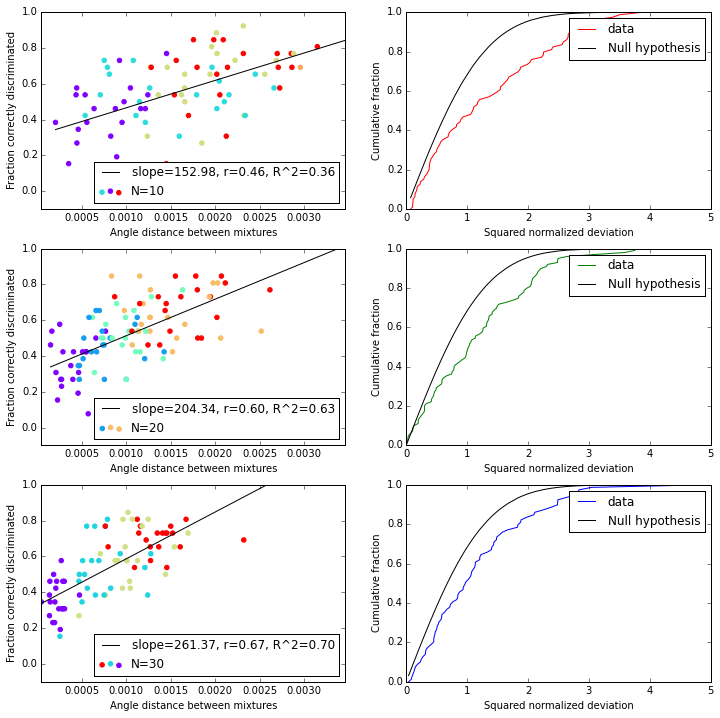

In [170]:
fitted_angles, fraction_correct = compute_angles(tests,results,CIDs_snitz,weights=fitted_weights)
plot_correct_vs_angles(fitted_angles, fraction_correct, color_d=True)

#### Fit and plot the weighted NMF descriptors

In [190]:
fitted_weights_nmf_200 = fmin_l_bfgs_b(f_norm,np.ones(200),fprime=None,args=(CIDs_nmf_200,1e-4,tests,results),approx_grad=True,maxiter=1e6)[0]

0.0412
0.0412
0.0412
0.0412
0.0412
0.0412
0.0412
0.0412
0.0397
0.0397
0.0397
0.0397
0.0397
0.0397
0.0397
0.0397
0.0397
0.0335
0.0335
0.0335
0.0335
0.0335
0.0335
0.0335
0.035
0.035
0.035
0.035
0.035
0.035
0.035
0.035
0.0261
0.0261
0.0261
0.0261
0.0261
0.0261
0.0261
0.0329
0.0329
0.0329
0.0329
0.0329
0.0329
0.0329
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0271
0.0238
0.0238
0.0238
0.0238
0.0238
0.0238
0.0238
0.0238
0.0239
0.0239
0.0239
0.0239
0.0239
0.0239
0.0239
0.0239
0.0239
0.0239
0.0223
0.0223
0.0223
0.0223
0.0223
0.0223
0.0223
0.0223
0.0219
0.0219
0.0219
0.0219
0.0219
0.0219
0.0219
0.0203
0.0203
0.0203
0.0203
0.0203
0.0213
0.0213
0.0213
0.0213
0.0213
0.0213
0.0213
0.0201
0.0201
0.0201
0.0201
0.0201
0.0201
0.0201
0.0201
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.0196
0.0196
0.0196
0.0196
0.0196
0.0196
0.0196
0.0196
0.0196
0.0196
0.0195
0.0195
0.0195
0.0195
0.0195
0.0195
0.0195
0.01

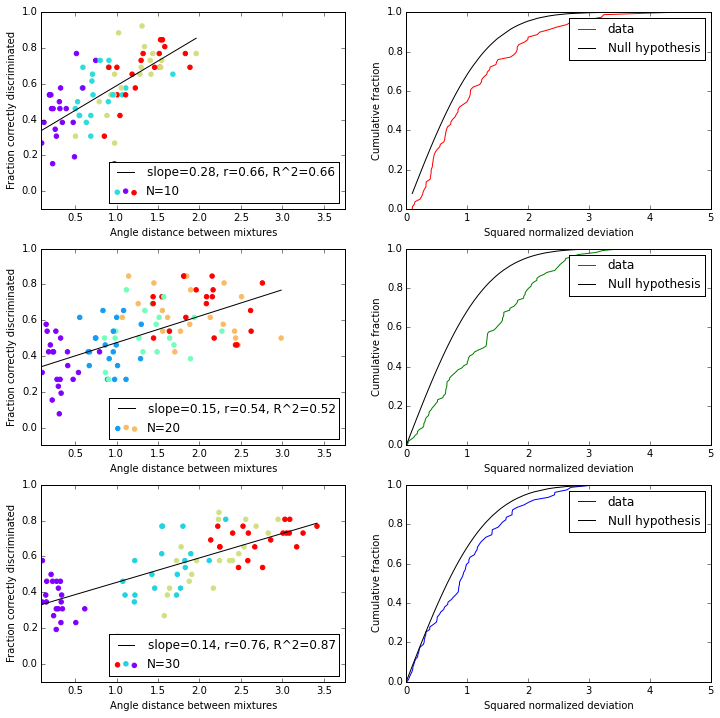

In [192]:
fitted_norms_nmf_alpha, fraction_correct = compute_norms(tests,results,CIDs_nmf_200,order=1,weights=fitted_weights_nmf_200)
plot_correct_vs_angles(fitted_norms_nmf_alpha, fraction_correct, color_d=True)

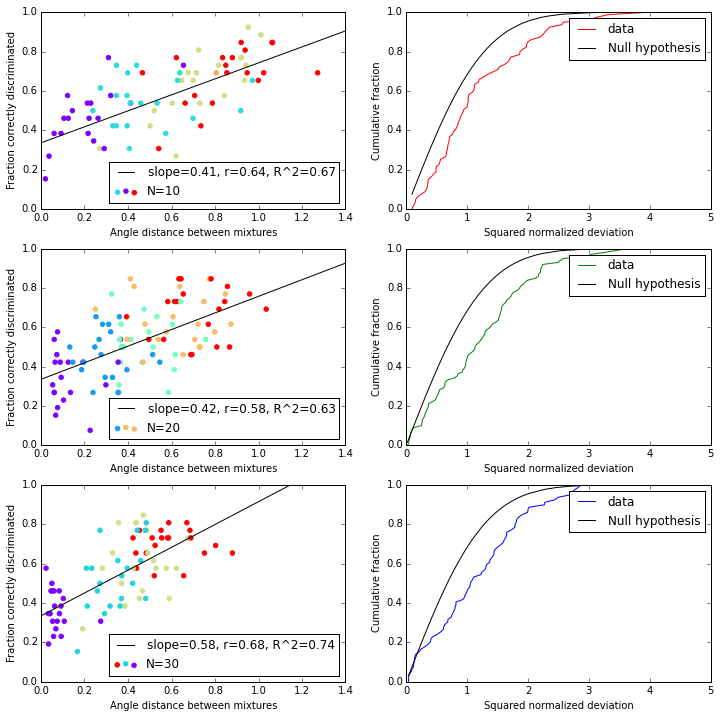

In [19]:
fitted_angles_nmf_alpha, fraction_correct = compute_angles(tests,results,CIDs_nmf_200,weights=fitted_weights_nmf_200)
plot_correct_vs_angles(fitted_angles_nmf_alpha, fraction_correct, color_d=True)

#### The number of significant NMF descriptors after weighting is about the same as the number of descriptors selected in Snitz et al, i.e about 20.

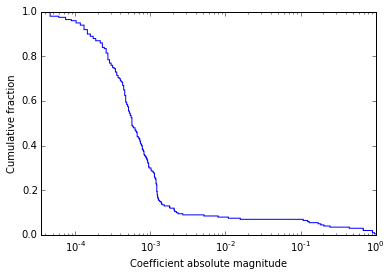

In [20]:
plt.hist(np.abs(fitted_weights_nmf_200),normed=True,cumulative=-1,bins=99999,histtype='step')
plt.xlim(3.5e-5,1)
plt.ylim(0,1)
plt.xscale('log')
plt.xlabel('Coefficient absolute magnitude')
_ = plt.ylabel('Cumulative fraction')

In [21]:
print("Of the 200 coefficients, only %d have absolute value > 0.002" % (np.abs(fitted_weights_nmf_200)>2e-3).sum())

Of the 200 coefficients, only 24 have absolute value > 0.002


#### How many molecular descriptors did the two methods select in commmon?

In [22]:
descriptor_indices_snitz = [descriptors.index(_) for _ in snitz_descriptors]
print("Snitz descriptor indices: %s" % descriptor_indices_snitz)
descriptor_indices_nmf = sorted(np.where(fitted_weights_nmf_200[:,np.newaxis] * nmf_200.components_ > 1.4)[1])
print("Notable NMF descriptor indices: %s" % descriptor_indices_nmf)
intersection = set(descriptor_indices_snitz).intersection(descriptor_indices_nmf)
print("They have %d descriptors in common: %s" % (len(intersection),intersection))

Snitz descriptor indices: [18, 43, 50, 95, 174, 288, 294, 320, 350, 406, 422, 429, 432, 476, 732, 993, 1004, 1015, 1039, 1199, 1294]
Notable NMF descriptor indices: [32, 42, 116, 149, 173, 174, 175, 176, 194, 369, 983, 994, 1005, 1016, 1027, 1038, 1288, 1323, 1424]
They have 1 descriptors in common: {174}


In [23]:
def p_match(intersection):
    slots = len(snitz_descriptors)
    matches = len(intersection)
    p = 1
    for i in range(matches):
        p *= (slots-i)/(len(descriptors)-i)
    for i in range(slots-matches):
        p *= (len(descriptors)-slots-i)/(len(descriptors)-matches-i)
    p *= trillion.get_n_combos(slots,matches)
    print("Under the null hypothesis, probability of %d matches out of %d with %d total descriptors is: %g" % (matches,slots,len(descriptors),p))
    
p_match(intersection)

Under the null hypothesis, probability of 1 matches out of 21 with 1433 total descriptors is: 0.231847


#### Not very many in common.  This suggests that one of both of these methods is not selecting particularly special molecular descriptors, probably in part because the descriptors are highly correlated.  This is a good reason to prefer the NMF version (or some other matrix decomposition), since the correlated needs to be removed.

#### Let's see how many we get in common if we construct a fake data set in which fraction discriminated is determined *entirely* by the angle using the Snitz descriptors and nothing else.

In [18]:
fake_results = []
max_angle = 0
for result in results:
    if result.test.N > 1:
        angle = result.test.angle(CIDs_snitz)
        max_angle = max(angle,max_angle)
for result in results:
    if result.test.N > 1:
        angle = result.test.angle(CIDs_snitz)
        p = 0.333+0.667*angle/(1.1*max_angle)
        fake_correct = np.random.binomial(1,p)
        fake_result = trillion.Result(result.test,result.subject_id,fake_correct)
        fake_results.append(fake_result)

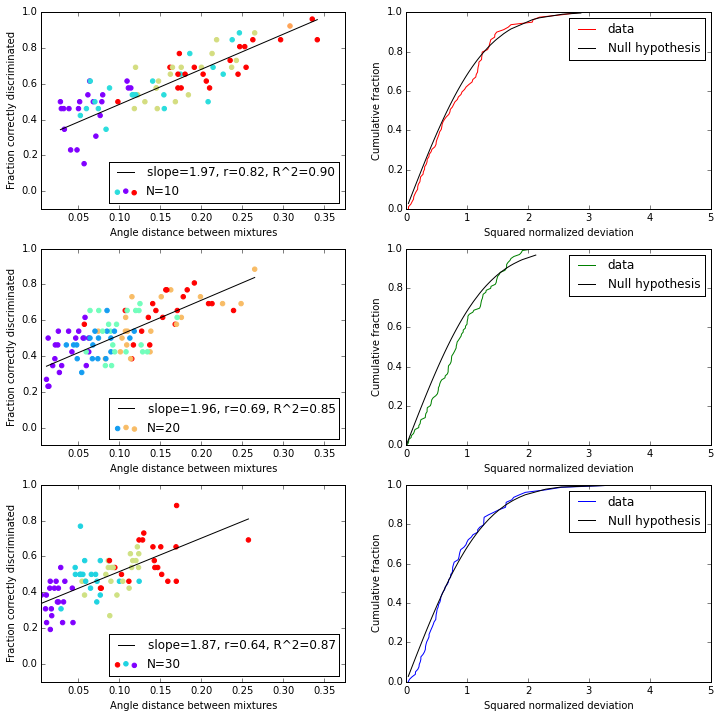

In [19]:
angles_fake, fraction_correct = compute_angles(tests,fake_results,CIDs_snitz)
plot_correct_vs_angles(angles_fake, fraction_correct, color_d=True)

In [25]:
fitted_weights_nmf_200_fake = fmin_l_bfgs_b(f,np.ones(200),fprime=None,args=(CIDs_nmf_200,1e-4,tests,fake_results),approx_grad=True,maxiter=1e6)[0]

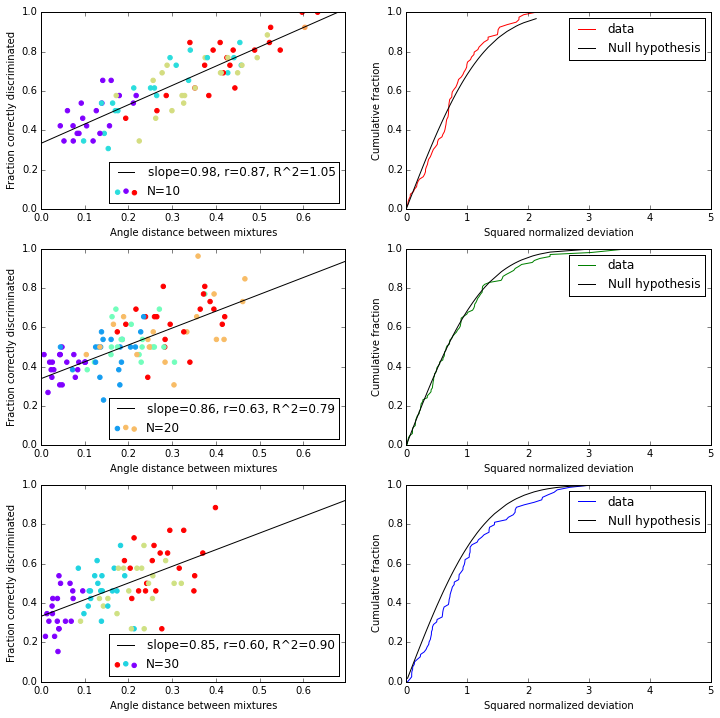

In [31]:
fitted_angles_nmf_200_fake, fraction_correct = compute_angles(tests,fake_results,CIDs_nmf_200,weights=fitted_weights_nmf_200_fake)
plot_correct_vs_angles(fitted_angles_nmf_200_fake, fraction_correct, color_d=True)

In [26]:
print("Of the 200 coefficients, only %d have absolute value > 0.002" % (np.abs(fitted_weights_nmf_200_fake)>2e-3).sum())

Of the 200 coefficients, only 29 have absolute value > 0.002


In [27]:
descriptor_indices_snitz = [descriptors.index(_) for _ in snitz_descriptors]
print("Snitz descriptor indices: %s" % descriptor_indices_snitz)
descriptor_indices_nmf = sorted(np.where(fitted_weights_nmf_200_fake[:,np.newaxis] * nmf_200.components_ > 0.45)[1])
print("Notable NMF descriptor indices: %s" % descriptor_indices_nmf)
intersection = set(descriptor_indices_snitz).intersection(descriptor_indices_nmf)
print("They have %d descriptors in common: %s" % (len(intersection),intersection))

Snitz descriptor indices: [18, 43, 50, 95, 174, 288, 294, 320, 350, 406, 422, 429, 432, 476, 732, 993, 1004, 1015, 1039, 1199, 1294]
Notable NMF descriptor indices: [16, 171, 179, 637, 638, 639, 841, 982, 984, 993, 995, 1004, 1006, 1015, 1017, 1026, 1028, 1037, 1039, 1281, 1358, 1405]
They have 4 descriptors in common: {1039, 993, 1004, 1015}


In [28]:
p_match(intersection)

Under the null hypothesis, probability of 4 matches out of 21 with 1433 total descriptors is: 0.000166846


#### A few more matches, and enough to be significantly different from chance, but still not that impressive

In [141]:
# Optimize not on total correlation, but on average of correlation for each value of R (replacements).
def f2(weights,descriptors,alpha,tests,results):
    angles = {}
    fraction_correct = {}
    for test in tests.values():
        if test.N > 1:
            key = '%d_%d' % (test.N,test.r)
            if key not in fraction_correct:
                angles[key] = []
                fraction_correct[key] = []
            angles[key].append(test.angle(descriptors,weights=weights,method='sum'))
            fraction_correct[key].append(test.fraction_correct(results))
    r2s = []
    sses = []
    for key in angles:
        if key.split('_')[1] == '20':
            continue
        angles[key] = np.array(angles[key])
        fraction_correct[key] = np.array(fraction_correct[key])
        x = np.concatenate((angles[key],np.zeros(100)))
        y = np.concatenate((fraction_correct[key],0.33333*np.ones(100)))
        slope, intercept, _, _, _ = linregress(x,y)
        #x = angles[key]
        #y = fraction_correct[key]
        #a,n = fmin_tnc(f_hill,[0.1,2],approx_grad=True,args=(x,y),bounds=((0,99),(-99,99)))[0]
        slope, intercept, _ , _, _ = linregress(x,y)
        #p_d = 1.0 / (1.0 + (x/a)**(-n))
        #prediction = 1.0/3 + p_d*(2.0/3)
        prediction = np.array([intercept + slope*angle for angle in angles[key]])
        r2 = get_r2(prediction,fraction_correct[key])
        sse = np.mean((prediction-fraction_correct[key])**2)
        r2s.append(r2)
        sses.append(sse)
    obj = np.mean(sses) + alpha*np.abs(weights).sum()
    if np.random.randint(25) == 0:
        print('%.3g' % obj)#,len(np.where(np.abs(weights)>0.1)[0]),r2s)
    return obj

In [140]:
fitted_weights_R = np.ones(len(snitz_descriptors))
fitted_weights_R = fmin_l_bfgs_b(f2,fitted_weights_R,fprime=None,args=(CIDs_snitz,1e-4,tests,results),approx_grad=True,maxiter=1e6)[0]

0.505198980593 0.174516758536
0.207040191001 2.0210043491
0.353824371288 1.96790941487
0.22850010132 1.61611113516
1.48089143721e-05 -0.0195269612716
0.194195220079 1.44487256643
0.615590605868 0.699719634519
0.209676381692

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


 0.40091115572
0.122972340616 1.39660782995
0.428417260881 0.625036217364
0.0323426950774 0.089656056357
0.223413737802 2.01372012129
0.539608768777 0.165936339731
0.207096711587 2.02101543452
0.353809780057 1.96791125967
0.228496950687 1.61609492668
0.319702351605 0.293134273469
0.32227636036 0.945921935419
0.436669247292 0.837752401578
0.209676381692 0.40091115572
0.122973647174 1.39658247003
0.517645403431 0.552803019128
0.0318261104401 0.0880556125639
0.223416140275 2.01371791777
0.544416187606 0.15909690004
0.207094293119 2.02101495381
0.353824370476 1.96790941161
0.228500651111 1.61610892199
0.405046230693 0.219760694208
0.194705842493 1.43930765651
0.610704479229 0.701688890725
0.207805510656 0.391778718091
0.122973645809 1.39658250609
0.399923538098 0.645752194872
0.0362449778816 0.10348201539
0.223521903372 2.01376002352
2.05402704552e-05 -0.0259123946993
0.207025465581 2.02100145955
0.353809779647 1.9679112613
0.228500662012 1.61612212369
0.405147789138 0.219593437756
0.32234

KeyboardInterrupt: 

In [138]:
fitted_weights_R

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

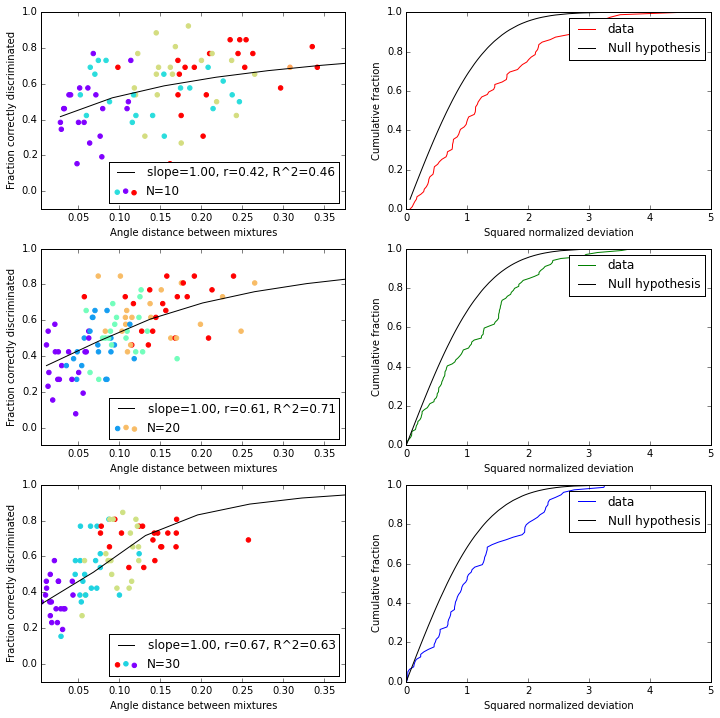

In [137]:
fitted_angles_R, fraction_correct = compute_angles(tests,results,CIDs_snitz,weights=fitted_weights_R)
plot_correct_vs_angles(fitted_angles_R, fraction_correct, color_d=True)

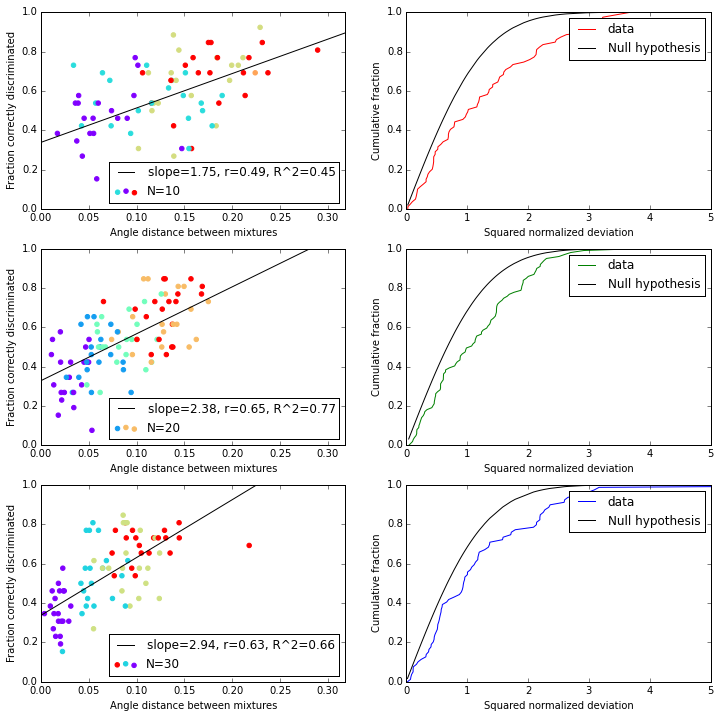

In [40]:
fitted_angles_R, fraction_correct = compute_angles(tests,results,CIDs_snitz,weights=fitted_weights_R)
plot_correct_vs_angles(fitted_angles_R, fraction_correct, color_d=True)

In [17]:
fitted_weights_nmf_200_R = np.ones(200)
fitted_weights_nmf_200_R = fmin_l_bfgs_b(f2,fitted_weights_nmf_200_R,fprime=None,args=(CIDs_nmf_200,1e-4,tests,results),approx_grad=True,maxiter=1e6)[0]

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0384
0.0365
0.0365
0.0365
0.0365
0.0365
0.0321
0.0321
0.0321
0.0321
0.0321
0.0321
0.0321
0.0284
0.0284
0.0284
0.0284
0.0284
0.0284
0.0284
0.0284
0.0284
0.0284
0.036
0.036
0.036
0.036
0.036
0.036
0.036
0.036
0.036
0.036
0.036
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0226
0.0705
0.0705
0.0705
0.0705
0.0705
0.0705
0.0705
0.0705
0.0259
0.0259
0.0259
0.0259
0.0259
0.0259
0.0222
0.0222
0.0222
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0215
0.0209
0.0209
0.0209
0.0209
0.0209
0.0209
0.0209
0.0209
0.0209
0.0204
0.0204
0.0204
0.0204
0.0204
0.0204
0.0204
0.0199
0.0199
0.0199
0.0199
0.0199
0.0199
0.0199
0.0195
0.0195
0.0195
0.0195
0.0195
0.0195
0.0195
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.019
0.0184
0.0184
0.0184
0.0184
0.0184
0.0184
0.018

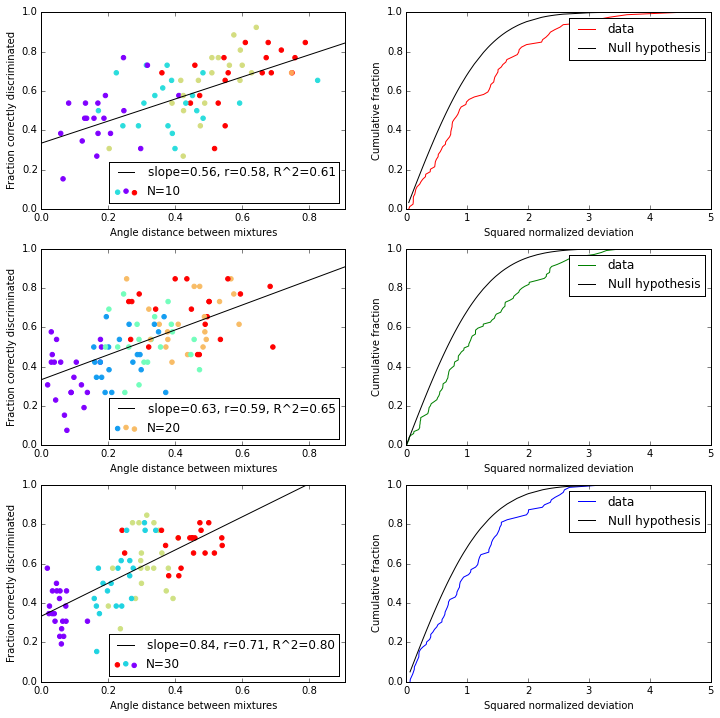

In [18]:
fitted_angles_nmf_200_R, fraction_correct = compute_angles(tests,results,CIDs_nmf_200,weights=fitted_weights_nmf_200_R)
plot_correct_vs_angles(fitted_angles_nmf_200_R, fraction_correct, color_d=True)

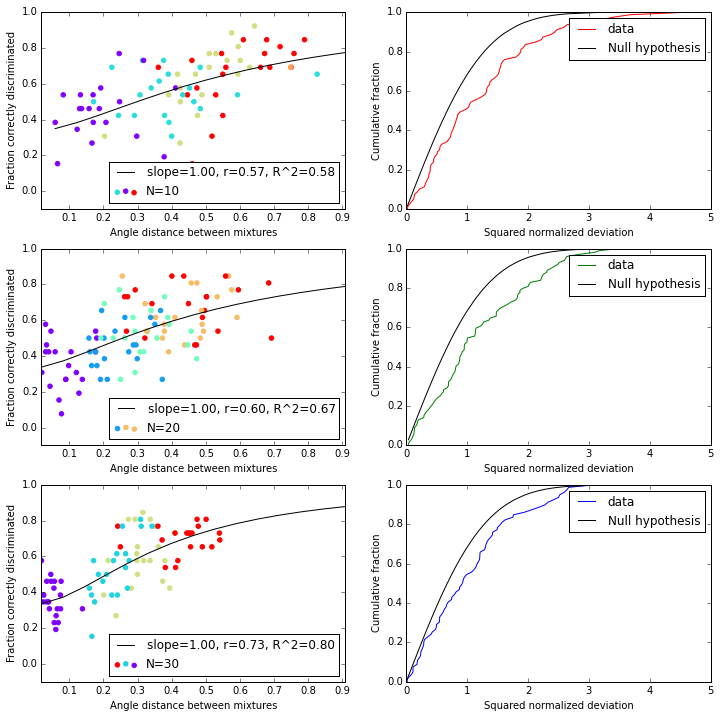

In [134]:
fitted_angles_nmf_200_R, fraction_correct = compute_angles(tests,results,CIDs_nmf_200,
                                                           weights=fitted_weights_nmf_200_R,
                                                           method='sum',
                                                           method_param=1.0)
plot_correct_vs_angles(fitted_angles_nmf_200_R, fraction_correct, color_d=True)

In [119]:
p_c[7],(y*26)[7]

(0.85051715761393876, 14.999999999999998)